Loading data...
Building graph...
Graph built with 10980 nodes and 21090 edges.
Precomputing neighbors...


100%|██████████| 10980/10980 [00:00<00:00, 421653.88it/s]


Generating negative samples...
Generated 1000 negative samples...
Generated 2000 negative samples...
Generated 3000 negative samples...
Generated 4000 negative samples...
Generated 5000 negative samples...
Generated 6000 negative samples...
Generated 7000 negative samples...
Generated 8000 negative samples...
Generated 9000 negative samples...
Generated 10000 negative samples...
Generated 11000 negative samples...
Generated 12000 negative samples...
Generated 13000 negative samples...
Generated 14000 negative samples...
Generated 15000 negative samples...
Generated 16000 negative samples...
Generated 17000 negative samples...
Generated 18000 negative samples...
Generated 19000 negative samples...
Generated 20000 negative samples...
Generated 21000 negative samples...
Created training data with 42180 samples.
Starting feature engineering...
Engineering features for training data...


100%|██████████| 42180/42180 [00:03<00:00, 11802.46it/s]


Engineering features for test data...


100%|██████████| 8000/8000 [00:00<00:00, 16523.02it/s]


Feature engineering complete.
Train features shape: (42180, 11)
Test features shape: (8000, 11)
Training SVM model...
Validation Accuracy: 0.7578236130867709
Validation AUC: 0.9303993856850037


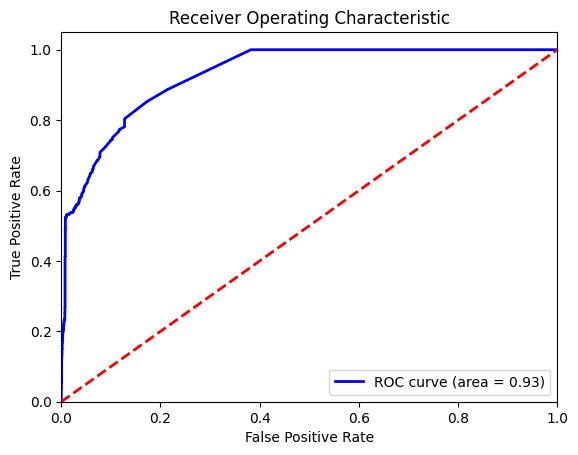

Predicting on test data...
Generating submission file...
Done. Submission file 'submission.csv' created.


In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# --- 1. Load Data & Build Graph ---
print("Loading data...")
train_df = pd.read_csv(r'C:\Users\USER\Downloads\train.csv')
test_df = pd.read_csv(r'C:\Users\USER\Downloads\test.csv')

print("Building graph...")
G = nx.DiGraph()
G.add_edges_from(train_df[['node1', 'node2']].values)
nodes = list(G.nodes())
n_nodes = len(nodes)
node_set = set(nodes)
print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Precompute neighbors for efficiency
print("Precomputing neighbors...")
preds = {node: set(G.predecessors(node)) for node in tqdm(nodes)}
succs = {node: set(G.successors(node)) for node in tqdm(nodes)}
out_degree = {node: G.out_degree(node) for node in tqdm(nodes)}
in_degree = {node: G.in_degree(node) for node in tqdm(nodes)}

# --- 2. Generate Negative Samples ---
print("Generating negative samples...")
negative_samples = []
target_neg_count = len(train_df)
existing_edges = set(map(tuple, train_df[['node1', 'node2']].values))

while len(negative_samples) < target_neg_count:
    u = random.choice(nodes)
    v = random.choice(nodes)
    if u != v and (u, v) not in existing_edges and (u, v) not in negative_samples:
        negative_samples.append((u, v))
    if len(negative_samples) % 1000 == 0:
        print(f"Generated {len(negative_samples)} negative samples...")

neg_df = pd.DataFrame(negative_samples, columns=['node1', 'node2'])
neg_df['label'] = 0
pos_df = train_df.copy()
pos_df['label'] = 1

train_data = pd.concat([pos_df, neg_df], ignore_index=True)
print(f"Created training data with {len(train_data)} samples.")

# --- 3. Feature Engineering ---
print("Starting feature engineering...")

def get_features(df, G, preds, succs, out_degree, in_degree):
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        u, v = row['node1'], row['node2']
        feat = {}

        feat['out_degree_u'] = out_degree.get(u, 0)
        feat['in_degree_v'] = in_degree.get(v, 0)
        feat['pref_attach'] = feat['out_degree_u'] * feat['in_degree_v']

        u_succ = succs.get(u, set())
        v_succ = succs.get(v, set())
        u_pred = preds.get(u, set())
        v_pred = preds.get(v, set())

        common_succ = u_succ.intersection(v_succ)
        feat['common_succ'] = len(common_succ)
        union_succ_size = len(u_succ.union(v_succ))
        feat['jaccard_succ'] = feat['common_succ'] / union_succ_size if union_succ_size > 0 else 0
        feat['adamic_adar_succ'] = sum(1 / np.log(in_degree.get(w, 1) + 1) for w in common_succ)
        feat['ra_succ'] = sum(1 / (in_degree.get(w, 0) + 1e-6) for w in common_succ)

        common_pred = u_pred.intersection(v_pred)
        feat['common_pred'] = len(common_pred)
        union_pred_size = len(u_pred.union(v_pred))
        feat['jaccard_pred'] = feat['common_pred'] / union_pred_size if union_pred_size > 0 else 0
        feat['adamic_adar_pred'] = sum(1 / np.log(out_degree.get(w, 1) + 1) for w in common_pred)
        feat['ra_pred'] = sum(1 / (out_degree.get(w, 0) + 1e-6) for w in common_pred)

        features.append(feat)
    return pd.DataFrame(features)

print("Engineering features for training data...")
train_features = get_features(train_data, G, preds, succs, out_degree, in_degree)
X = train_features
y = train_data['label']

print("Engineering features for test data...")
test_features = get_features(test_df, G, preds, succs, out_degree, in_degree)
X_test = test_features

print("Feature engineering complete.")
print("Train features shape:", X.shape)
print("Test features shape:", X_test.shape)

# --- 4. Model Training ---
print("Training SVM model...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize SVM classifier
svm_clf = SVC(probability=True, random_state=42)

# Train the model
svm_clf.fit(X_train, y_train)

# Evaluate on validation set
val_preds = svm_clf.predict(X_val)
val_proba = svm_clf.predict_proba(X_val)[:, 1]
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds)}")
print(f"Validation AUC: {roc_auc_score(y_val, val_proba)}")

# --- ROC AUC Curve ---
fpr, tpr, _ = roc_curve(y_val, val_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, val_proba))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# --- 5. Prediction on Test Data ---
print("Predicting on test data...")
test_predictions = svm_clf.predict(X_test)

# --- 6. Submission File ---
print("Generating submission file...")
submission_df = pd.DataFrame({'idx': test_df['idx'], 'prediction': test_predictions})
submission_df.to_csv('submission.csv', index=False)

print("Done. Submission file 'submission.csv' created.")

Loading data...
Building graph...
Graph built with 10980 nodes and 21090 edges.
Precomputing neighbors...


100%|██████████| 10980/10980 [00:00<00:00, 357652.31it/s]


Generating negative samples...
Generated 1000 negative samples...
Generated 2000 negative samples...
Generated 3000 negative samples...
Generated 4000 negative samples...
Generated 5000 negative samples...
Generated 6000 negative samples...
Generated 7000 negative samples...
Generated 8000 negative samples...
Generated 9000 negative samples...
Generated 10000 negative samples...
Generated 11000 negative samples...
Generated 12000 negative samples...
Generated 13000 negative samples...
Generated 14000 negative samples...
Generated 15000 negative samples...
Generated 16000 negative samples...
Generated 17000 negative samples...
Generated 18000 negative samples...
Generated 19000 negative samples...
Generated 20000 negative samples...
Generated 21000 negative samples...
Created training data with 42180 samples.
Starting feature engineering...
Engineering features for training data...


100%|██████████| 42180/42180 [00:04<00:00, 10124.80it/s]


Engineering features for test data...


100%|██████████| 8000/8000 [00:00<00:00, 11700.38it/s]


Feature engineering complete.
Train features shape: (42180, 11)
Test features shape: (8000, 11)
Training Decision Tree model...
Validation Accuracy: 0.8584637268847796
Validation AUC: 0.9517137767399801


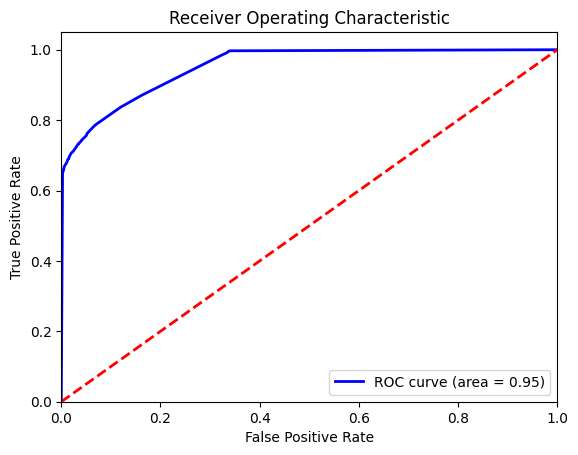

Predicting on test data...
Generating submission file...
Done. Submission file 'submission.csv' created.


In [19]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# --- 1. Load Data & Build Graph ---
print("Loading data...")
train_df = pd.read_csv(r'C:\Users\USER\Downloads\train.csv')
test_df = pd.read_csv(r'C:\Users\USER\Downloads\test.csv')

print("Building graph...")
G = nx.DiGraph()
G.add_edges_from(train_df[['node1', 'node2']].values)
nodes = list(G.nodes())
n_nodes = len(nodes)
node_set = set(nodes)
print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Precompute neighbors for efficiency
print("Precomputing neighbors...")
preds = {node: set(G.predecessors(node)) for node in tqdm(nodes)}
succs = {node: set(G.successors(node)) for node in tqdm(nodes)}
out_degree = {node: G.out_degree(node) for node in tqdm(nodes)}
in_degree = {node: G.in_degree(node) for node in tqdm(nodes)}

# --- 2. Generate Negative Samples ---
print("Generating negative samples...")
negative_samples = []
target_neg_count = len(train_df)
existing_edges = set(map(tuple, train_df[['node1', 'node2']].values))

while len(negative_samples) < target_neg_count:
    u = random.choice(nodes)
    v = random.choice(nodes)
    if u != v and (u, v) not in existing_edges and (u, v) not in negative_samples:
        negative_samples.append((u, v))
    if len(negative_samples) % 1000 == 0:
        print(f"Generated {len(negative_samples)} negative samples...")

neg_df = pd.DataFrame(negative_samples, columns=['node1', 'node2'])
neg_df['label'] = 0
pos_df = train_df.copy()
pos_df['label'] = 1

train_data = pd.concat([pos_df, neg_df], ignore_index=True)
print(f"Created training data with {len(train_data)} samples.")

# --- 3. Feature Engineering ---
print("Starting feature engineering...")

def get_features(df, G, preds, succs, out_degree, in_degree):
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        u, v = row['node1'], row['node2']
        feat = {}

        feat['out_degree_u'] = out_degree.get(u, 0)
        feat['in_degree_v'] = in_degree.get(v, 0)
        feat['pref_attach'] = feat['out_degree_u'] * feat['in_degree_v']

        u_succ = succs.get(u, set())
        v_succ = succs.get(v, set())
        u_pred = preds.get(u, set())
        v_pred = preds.get(v, set())

        common_succ = u_succ.intersection(v_succ)
        feat['common_succ'] = len(common_succ)
        union_succ_size = len(u_succ.union(v_succ))
        feat['jaccard_succ'] = feat['common_succ'] / union_succ_size if union_succ_size > 0 else 0
        feat['adamic_adar_succ'] = sum(1 / np.log(in_degree.get(w, 1) + 1) for w in common_succ)
        feat['ra_succ'] = sum(1 / (in_degree.get(w, 0) + 1e-6) for w in common_succ)

        common_pred = u_pred.intersection(v_pred)
        feat['common_pred'] = len(common_pred)
        union_pred_size = len(u_pred.union(v_pred))
        feat['jaccard_pred'] = feat['common_pred'] / union_pred_size if union_pred_size > 0 else 0
        feat['adamic_adar_pred'] = sum(1 / np.log(out_degree.get(w, 1) + 1) for w in common_pred)
        feat['ra_pred'] = sum(1 / (out_degree.get(w, 0) + 1e-6) for w in common_pred)

        features.append(feat)
    return pd.DataFrame(features)

print("Engineering features for training data...")
train_features = get_features(train_data, G, preds, succs, out_degree, in_degree)
X = train_features
y = train_data['label']

print("Engineering features for test data...")
test_features = get_features(test_df, G, preds, succs, out_degree, in_degree)
X_test = test_features

print("Feature engineering complete.")
print("Train features shape:", X.shape)
print("Test features shape:", X_test.shape)

# --- 4. Model Training ---
print("Training Decision Tree model...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Train the model
dt_clf.fit(X_train, y_train)

# Evaluate on validation set
val_preds = dt_clf.predict(X_val)
val_proba = dt_clf.predict_proba(X_val)[:, 1]
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds)}")
print(f"Validation AUC: {roc_auc_score(y_val, val_proba)}")

# --- ROC AUC Curve ---
fpr, tpr, _ = roc_curve(y_val, val_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, val_proba))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# --- 5. Prediction on Test Data ---
print("Predicting on test data...")
test_predictions = dt_clf.predict(X_test)

# --- 6. Submission File ---
print("Generating submission file...")
submission_df = pd.DataFrame({'idx': test_df['idx'], 'prediction': test_predictions})
submission_df.to_csv('submission.csv', index=False)

print("Done. Submission file 'submission.csv' created.")

Loading data...
Building graph...
Graph built with 10980 nodes and 21090 edges.
Precomputing neighbors...


100%|██████████| 10980/10980 [00:00<00:00, 676888.43it/s]


Generating negative samples...
Generated 1000 negative samples...
Generated 2000 negative samples...
Generated 3000 negative samples...
Generated 4000 negative samples...
Generated 5000 negative samples...
Generated 6000 negative samples...
Generated 7000 negative samples...
Generated 8000 negative samples...
Generated 9000 negative samples...
Generated 10000 negative samples...
Generated 11000 negative samples...
Generated 12000 negative samples...
Generated 13000 negative samples...
Generated 14000 negative samples...
Generated 15000 negative samples...
Generated 16000 negative samples...
Generated 17000 negative samples...
Generated 18000 negative samples...
Generated 19000 negative samples...
Generated 20000 negative samples...
Generated 21000 negative samples...
Created training data with 42180 samples.
Starting feature engineering...
Engineering features for training data...


100%|██████████| 42180/42180 [00:01<00:00, 21261.37it/s]


Engineering features for test data...


100%|██████████| 8000/8000 [00:00<00:00, 20973.64it/s]


Feature engineering complete.
Train features shape: (42180, 11)
Test features shape: (8000, 11)
Training Decision Tree model...
Validation Accuracy: 0.8590564248458985
Validation AUC: 0.9520702105114771


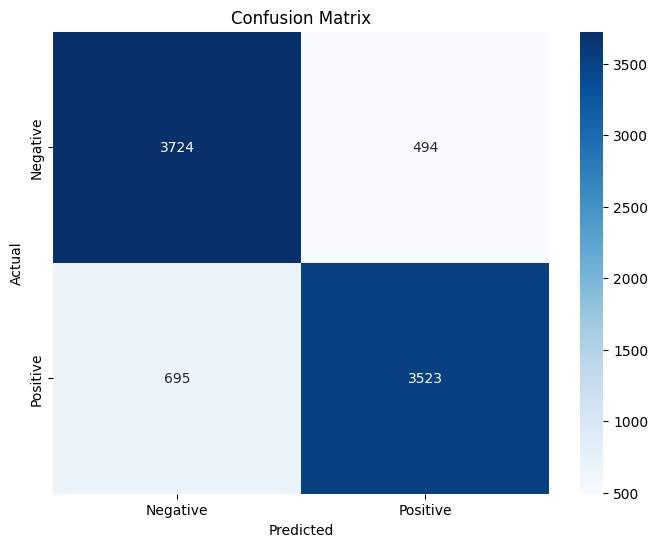

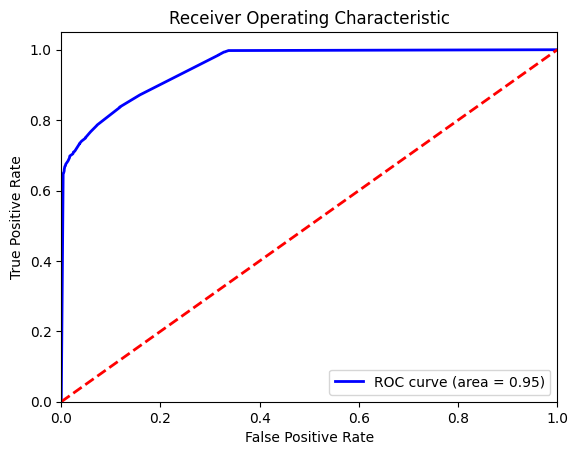

Predicting on test data...
Generating submission file...
Done. Submission file 'submission.csv' created.


In [21]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for heatmap
from tqdm import tqdm
import random

# --- 1. Load Data & Build Graph ---
print("Loading data...")
train_df = pd.read_csv(r'C:\Users\USER\Downloads\train.csv')
test_df = pd.read_csv(r'C:\Users\USER\Downloads\test.csv')

print("Building graph...")
G = nx.DiGraph()
G.add_edges_from(train_df[['node1', 'node2']].values)
nodes = list(G.nodes())
n_nodes = len(nodes)
node_set = set(nodes)
print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Precompute neighbors for efficiency
print("Precomputing neighbors...")
preds = {node: set(G.predecessors(node)) for node in tqdm(nodes)}
succs = {node: set(G.successors(node)) for node in tqdm(nodes)}
out_degree = {node: G.out_degree(node) for node in tqdm(nodes)}
in_degree = {node: G.in_degree(node) for node in tqdm(nodes)}

# --- 2. Generate Negative Samples ---
print("Generating negative samples...")
negative_samples = []
target_neg_count = len(train_df)
existing_edges = set(map(tuple, train_df[['node1', 'node2']].values))

while len(negative_samples) < target_neg_count:
    u = random.choice(nodes)
    v = random.choice(nodes)
    if u != v and (u, v) not in existing_edges and (u, v) not in negative_samples:
        negative_samples.append((u, v))
    if len(negative_samples) % 1000 == 0:
        print(f"Generated {len(negative_samples)} negative samples...")

neg_df = pd.DataFrame(negative_samples, columns=['node1', 'node2'])
neg_df['label'] = 0
pos_df = train_df.copy()
pos_df['label'] = 1

train_data = pd.concat([pos_df, neg_df], ignore_index=True)
print(f"Created training data with {len(train_data)} samples.")

# --- 3. Feature Engineering ---
print("Starting feature engineering...")

def get_features(df, G, preds, succs, out_degree, in_degree):
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        u, v = row['node1'], row['node2']
        feat = {}

        feat['out_degree_u'] = out_degree.get(u, 0)
        feat['in_degree_v'] = in_degree.get(v, 0)
        feat['pref_attach'] = feat['out_degree_u'] * feat['in_degree_v']

        u_succ = succs.get(u, set())
        v_succ = succs.get(v, set())
        u_pred = preds.get(u, set())
        v_pred = preds.get(v, set())

        common_succ = u_succ.intersection(v_succ)
        feat['common_succ'] = len(common_succ)
        union_succ_size = len(u_succ.union(v_succ))
        feat['jaccard_succ'] = feat['common_succ'] / union_succ_size if union_succ_size > 0 else 0
        feat['adamic_adar_succ'] = sum(1 / np.log(in_degree.get(w, 1) + 1) for w in common_succ)
        feat['ra_succ'] = sum(1 / (in_degree.get(w, 0) + 1e-6) for w in common_succ)

        common_pred = u_pred.intersection(v_pred)
        feat['common_pred'] = len(common_pred)
        union_pred_size = len(u_pred.union(v_pred))
        feat['jaccard_pred'] = feat['common_pred'] / union_pred_size if union_pred_size > 0 else 0
        feat['adamic_adar_pred'] = sum(1 / np.log(out_degree.get(w, 1) + 1) for w in common_pred)
        feat['ra_pred'] = sum(1 / (out_degree.get(w, 0) + 1e-6) for w in common_pred)

        features.append(feat)
    return pd.DataFrame(features)

print("Engineering features for training data...")
train_features = get_features(train_data, G, preds, succs, out_degree, in_degree)
X = train_features
y = train_data['label']

print("Engineering features for test data...")
test_features = get_features(test_df, G, preds, succs, out_degree, in_degree)
X_test = test_features

print("Feature engineering complete.")
print("Train features shape:", X.shape)
print("Test features shape:", X_test.shape)

# --- 4. Model Training ---
print("Training Decision Tree model...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Train the model
dt_clf.fit(X_train, y_train)

# Evaluate on validation set
val_preds = dt_clf.predict(X_val)
val_proba = dt_clf.predict_proba(X_val)[:, 1]
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds)}")
print(f"Validation AUC: {roc_auc_score(y_val, val_proba)}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# --- ROC AUC Curve ---
fpr, tpr, _ = roc_curve(y_val, val_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, val_proba))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# --- 5. Prediction on Test Data ---
print("Predicting on test data...")
test_predictions = dt_clf.predict(X_test)

# --- 6. Submission File ---
print("Generating submission file...")
submission_df = pd.DataFrame({'idx': test_df['idx'], 'prediction': test_predictions})
submission_df.to_csv('submission.csv', index=False)

print("Done. Submission file 'submission.csv' created.")

Loading data...
Building graph...
Graph built with 10980 nodes and 21090 edges.
Precomputing neighbors...


100%|██████████| 10980/10980 [00:00<00:00, 1220347.08it/s]

Generating negative samples...
Generated 1000 negative samples...


Generated 2000 negative samples...
Generated 3000 negative samples...
Generated 4000 negative samples...
Generated 5000 negative samples...
Generated 6000 negative samples...
Generated 7000 negative samples...
Generated 8000 negative samples...
Generated 9000 negative samples...
Generated 10000 negative samples...
Generated 11000 negative samples...
Generated 12000 negative samples...
Generated 13000 negative samples...
Generated 14000 negative samples...
Generated 15000 negative samples...
Generated 16000 negative samples...
Generated 17000 negative samples...
Generated 18000 negative samples...
Generated 19000 negative samples...
Generated 20000 negative samples...
Generated 21000 negative samples...
Created training data with 42180 samples.
Starting feature engineering...
Engineering features for training data...


100%|██████████| 42180/42180 [00:01<00:00, 22171.81it/s]


Engineering features for test data...


100%|██████████| 8000/8000 [00:00<00:00, 21561.98it/s]


Feature engineering complete.
Train features shape: (42180, 11)
Test features shape: (8000, 11)
Training Decision Tree model...
Validation Accuracy: 0.8601232811759127
Validation AUC: 0.9529126622317459


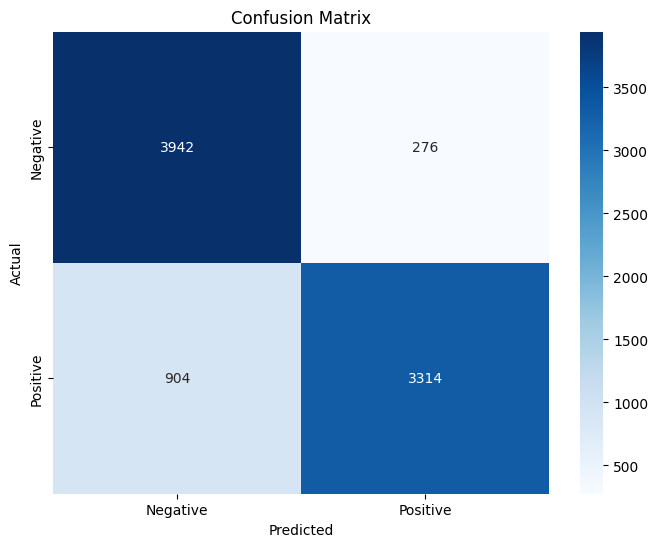

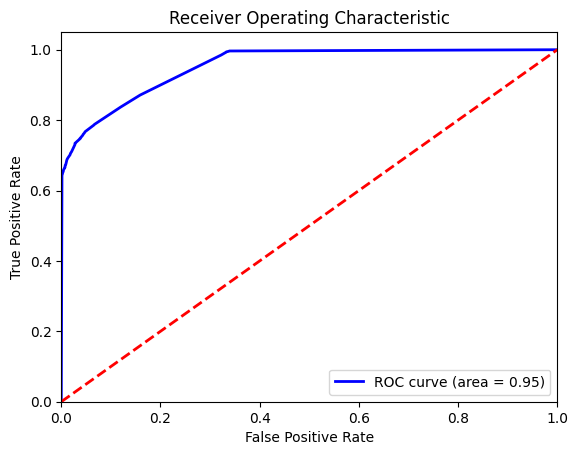

Predicting on test data...
Generating submission file...
Done. Submission file 'submission.csv' created.


'\'\'\nimport numpy as np\n\n# --- 7. Finalize Graph Visualization ---\nplt.figure(figsize=(12, 8))\npos = nx.spring_layout(G)  # Use spring layout for positioning\n\n# Get degrees\ndegrees = np.array([G.degree(node) for node in G.nodes()])\n\n# Lighter color mapping\ncolor_map = [\'lightcoral\' if degree < 5 else \'lightblue\' for degree in degrees]\n\n# Slightly larger node sizes\nnode_sizes = [50 for _ in G.nodes()]  # Slightly larger size\nnx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=color_map, alpha=0.6)  # Moderate transparency\n\n# Draw edges with color variations (if applicable)\nedge_widths = [1.0 for _ in G.edges()]  # Standard width for edges\nnx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color=\'gray\')  # Gray edges for contrast\n\n# Optionally draw labels for key nodes\n# labels = {node: node for node in list(G.nodes())[:10]}  # Example: label first 10 nodes\n# nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)\n\nplt.title(

In [8]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for heatmap
from tqdm import tqdm
import random

# --- 1. Load Data & Build Graph ---
print("Loading data...")
train_df = pd.read_csv(r'C:\Users\USER\Downloads\train.csv')
test_df = pd.read_csv(r'C:\Users\USER\Downloads\test.csv')

print("Building graph...")
G = nx.DiGraph()
G.add_edges_from(train_df[['node1', 'node2']].values)
nodes = list(G.nodes())
n_nodes = len(nodes)
node_set = set(nodes)
print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Precompute neighbors for efficiency
print("Precomputing neighbors...")
preds = {node: set(G.predecessors(node)) for node in tqdm(nodes)}
succs = {node: set(G.successors(node)) for node in tqdm(nodes)}
out_degree = {node: G.out_degree(node) for node in tqdm(nodes)}
in_degree = {node: G.in_degree(node) for node in tqdm(nodes)}

# --- 2. Generate Negative Samples ---
print("Generating negative samples...")
negative_samples = []
target_neg_count = len(train_df)
existing_edges = set(map(tuple, train_df[['node1', 'node2']].values))

while len(negative_samples) < target_neg_count:
    u = random.choice(nodes)
    v = random.choice(nodes)
    if u != v and (u, v) not in existing_edges and (u, v) not in negative_samples:
        negative_samples.append((u, v))
    if len(negative_samples) % 1000 == 0:
        print(f"Generated {len(negative_samples)} negative samples...")

neg_df = pd.DataFrame(negative_samples, columns=['node1', 'node2'])
neg_df['label'] = 0
pos_df = train_df.copy()
pos_df['label'] = 1

train_data = pd.concat([pos_df, neg_df], ignore_index=True)
print(f"Created training data with {len(train_data)} samples.")

# --- 3. Feature Engineering ---
print("Starting feature engineering...")

def get_features(df, G, preds, succs, out_degree, in_degree):
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        u, v = row['node1'], row['node2']
        feat = {}

        feat['out_degree_u'] = out_degree.get(u, 0)
        feat['in_degree_v'] = in_degree.get(v, 0)
        feat['pref_attach'] = feat['out_degree_u'] * feat['in_degree_v']

        u_succ = succs.get(u, set())
        v_succ = succs.get(v, set())
        u_pred = preds.get(u, set())
        v_pred = preds.get(v, set())

        common_succ = u_succ.intersection(v_succ)
        feat['common_succ'] = len(common_succ)
        union_succ_size = len(u_succ.union(v_succ))
        feat['jaccard_succ'] = feat['common_succ'] / union_succ_size if union_succ_size > 0 else 0
        feat['adamic_adar_succ'] = sum(1 / np.log(in_degree.get(w, 1) + 1) for w in common_succ)
        feat['ra_succ'] = sum(1 / (in_degree.get(w, 0) + 1e-6) for w in common_succ)

        common_pred = u_pred.intersection(v_pred)
        feat['common_pred'] = len(common_pred)
        union_pred_size = len(u_pred.union(v_pred))
        feat['jaccard_pred'] = feat['common_pred'] / union_pred_size if union_pred_size > 0 else 0
        feat['adamic_adar_pred'] = sum(1 / np.log(out_degree.get(w, 1) + 1) for w in common_pred)
        feat['ra_pred'] = sum(1 / (out_degree.get(w, 0) + 1e-6) for w in common_pred)

        features.append(feat)
    return pd.DataFrame(features)

print("Engineering features for training data...")
train_features = get_features(train_data, G, preds, succs, out_degree, in_degree)
X = train_features
y = train_data['label']

print("Engineering features for test data...")
test_features = get_features(test_df, G, preds, succs, out_degree, in_degree)
X_test = test_features

print("Feature engineering complete.")
print("Train features shape:", X.shape)
print("Test features shape:", X_test.shape)

# --- 4. Model Training ---
print("Training Decision Tree model...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Train the model
dt_clf.fit(X_train, y_train)

# Evaluate on validation set
val_preds = dt_clf.predict(X_val)
val_proba = dt_clf.predict_proba(X_val)[:, 1]
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds)}")
print(f"Validation AUC: {roc_auc_score(y_val, val_proba)}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# --- ROC AUC Curve ---
fpr, tpr, _ = roc_curve(y_val, val_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, val_proba))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# --- 5. Prediction on Test Data ---
print("Predicting on test data...")
test_predictions = dt_clf.predict(X_test)

# --- 6. Submission File ---
print("Generating submission file...")
submission_df = pd.DataFrame({'idx': test_df['idx'], 'prediction': test_predictions})
submission_df.to_csv('submission.csv', index=False)

print("Done. Submission file 'submission.csv' created.")
import random
'''''
import numpy as np

# --- 7. Finalize Graph Visualization ---
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Use spring layout for positioning

# Get degrees
degrees = np.array([G.degree(node) for node in G.nodes()])

# Lighter color mapping
color_map = ['lightcoral' if degree < 5 else 'lightblue' for degree in degrees]

# Slightly larger node sizes
node_sizes = [50 for _ in G.nodes()]  # Slightly larger size
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=color_map, alpha=0.6)  # Moderate transparency

# Draw edges with color variations (if applicable)
edge_widths = [1.0 for _ in G.edges()]  # Standard width for edges
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color='gray')  # Gray edges for contrast

# Optionally draw labels for key nodes
# labels = {node: node for node in list(G.nodes())[:10]}  # Example: label first 10 nodes
# nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Enhanced Graph Visualization with Links")
plt.axis('off')  # Turn off axis
plt.show()
'''''